# Show how K-bMOM behave when K is unknown and data are polluted

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from RobustClustering import KbMOM, kmedianpp_init

import matplotlib.pyplot as plt
import random as random_pck
import numpy as np
from scipy.spatial.distance import cdist
from collections import Counter

## Make data

In [3]:
from sklearn.datasets import make_blobs

In [4]:
n_intlier = 1000
dim = 2
nb_outliers_around_inlier = 79
nb_outliers_far_from_inlier = 13
random_state = 665548366
K_true = 9

In [5]:
X_in,y_in,centers = make_blobs(n_samples=n_intlier,n_features=dim,centers=K_true,return_centers=True,random_state=random_state)
X_out_1,y_out_1 = make_blobs(n_samples=nb_outliers_around_inlier,n_features=dim,centers=1,random_state=int(random_state/2))
X_out_2,y_out_2 = make_blobs(n_samples=nb_outliers_far_from_inlier,n_features=dim,centers=1,random_state=int(random_state/4))
X = np.concatenate([X_in,5*(X_out_1-X_out_1.mean(axis=0))+X_in.mean(axis=0),50*(X_out_2-X_out_2.mean(axis=0))+X_in.mean(axis=0)],axis=0)
y_in  = np.tile(A=0,reps=len(y_in))
y_out_1 = np.tile(A=max(y_in)+1,reps=len(y_out_1))
y_out_2 = np.tile(A=max(y_in)+1,reps=len(y_out_2))
y = np.concatenate([y_in,y_out_1,y_out_2])

how many datapoints?

In [6]:
n,_ = X.shape
n

1092

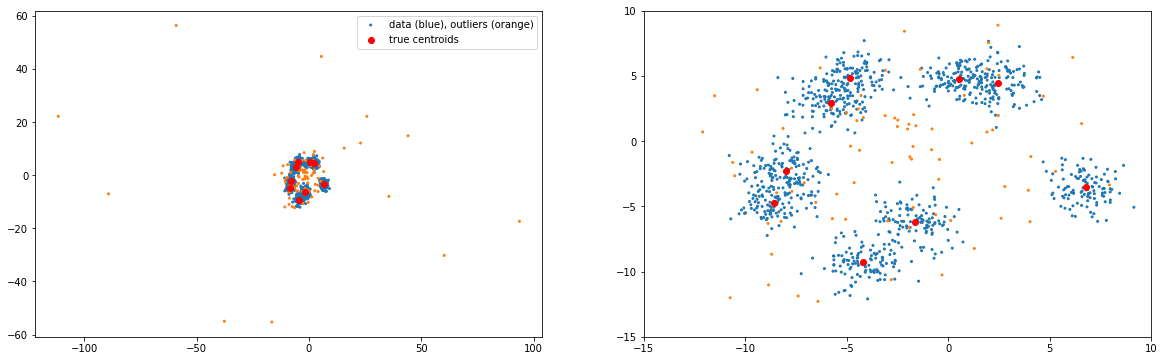

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
color_func = plt.get_cmap('tab10')
colors = [color_func(cluster) for cluster in y]
# fig 1: all data
ax[0].scatter(X[:,0],X[:,1],c=colors,s=4,label='data (blue), outliers (orange)')
ax[0].scatter(centers[:,0],centers[:,1],c='red',label='true centroids')
ax[0].legend()
# fig 2: zoom
ax[1].scatter(X[:,0],X[:,1],c=colors,s=4,label='data (blue), outliers (orange)')
ax[1].scatter(centers[:,0],centers[:,1],c='red',label='true centroids')
ax[1].set_xlim(-15,10)
ax[1].set_ylim(-15,10)
fig.show()

## block_size and number_of_block are central in KbMOM

We are in a case where their is corruption. But in real life one does not know exactly how many ourliers there are.
We know there are 1092 datapoints. Let say we there are 200 outliers (that more than it is but let's be safe here).

In [8]:
nb_outliers = 200

In [9]:
KbMOM.block_size_max(n=n,nb_outliers=nb_outliers)

3

This means our blocks will have 3 data points. that's definately too small. Let's then say a too small value:

In [10]:
nb_outliers = 50
block_size = KbMOM.block_size_max(n=n,nb_outliers=nb_outliers)
block_size

14

14 could do the job. With blocks with size 14 one can search for 3 o 4 centroids. One can also use the data depth feature.

Let say we are going to only consider the huge corruption induced by points far away from the main group (estimated to be 20 of them)

In [11]:
nb_outliers = 20
block_size = KbMOM.block_size_max(n=n,nb_outliers=nb_outliers)
block_size

37

In [12]:
KbMOM.minimal_number_of_blocks(n=n,nb_outliers=nb_outliers,block_size=block_size,alpha=0.05)

70001

70001 blocks is a bit too much, the algorithmic complexity will be too big.
This number is only the smallest number that you should take if you want to be sure that your median block won't be infected when it has size 37 and while 20 big outliers are roaming out there.

There are two way to reduce it:

- decrease the confidence value
- decrease the size of blocks

In [13]:
block_size = 35
alpha = 0.10
confidence = 1 - alpha
number_of_blocks = KbMOM.minimal_number_of_blocks(n=n,nb_outliers=nb_outliers,block_size=block_size,alpha=alpha)
number_of_blocks

2062

This number is way smaller. We take that.

In [14]:
number_of_blocks, block_size, confidence

(2062, 35, 0.9)

## KbMOM algorithm:

Initialize centroids:

- make lots of blocks at random with replacement from the data (use parameter number_of_blocks and block_size)
- lauch a non robust initialization in each block (implemented: kmeans++ and kmedians++, parameter: init_by_kmeanspp)
- compute the risk (a.k.a loss or distorsion) in each block
- select the block that achieves the median risk (implemented: any quantile you want)
- take as initialization centroids the one of the median block
    
Refine centroids (do something very similar):

- make lots of blocks (Either to make them completely at random or you force the algo to take a specified amount of data from each cluster)
- every data in the block are already assigned to a cluster, then one can compute the average point of these points inside the blocks (main difference)
- compute the risk in each block
- select the block that achieves the median risk (implemented: any quantile you want)
- take the average points as new centroids
- recompute the assignment of the data to clusters

There are some others features that do not impact the routine described above:

- the clusters are not only give as assignment vectors but also as composition dictionary
- use the selection of a particular block to compute a data depth
- the article of Saumard, Saumard and Genetay explained they average the 10 last centers. It is not implemented but since the method outputs the sequence of all centroids, you can do it if you find it better.

# K-bMOM

## KbMOM - case where we use few centroids

Assume one does not know how many centers there are. It could be a good idea to look for 4, 5, 6 or 7 centroids. With KbMOM, these centroids should be located where the density of points is big, even if there are 5 blue groups and 9 true centers.

We are going to do 30 iteration because it will help you to get a meaningfull data depth. "Convergence" should be attained before that. (I wrote "Convergence" because I mean macroscopic convergence (global centroids location), KbMOM does not converges in the same way as Kmeans. No criterion decreases along the iteration due to the stochastic process that create blocks)

In [48]:
K = 4
max_iter = 30

In [49]:
kbmom = KbMOM(
    X=X,
    K=K,
    number_of_blocks=number_of_blocks,
    block_size = block_size,
    max_iter = max_iter,
    q_quantile = 0.5, # 0.5 means KbMOM will use the median as working quantile
    estimated_number_of_outliers = None,
    confidence = confidence,
    Aitkens_criterion_allowed = False,
    Aitkens_threshold = 0.00001,
    initial_centers = None, # KbMOM will initialize centroids
    init_by_kmeanspp = True, # KbMOM will use kmeans++ in its initialization procedure
    nb_min_repr_by_cluster = 2, # let force KbMOM to have 2 points of each cluster in all blocks
    data_depth_strategy="block_members_distances",
    random_state = 2
)

In [50]:
%%time

output = kbmom.fit(X)

CPU times: user 24 s, sys: 148 ms, total: 24.2 s
Wall time: 24 s


In [51]:
output.keys()

dict_keys(['centroids', 'labels', 'clusters_composition', 'q_quantile_block_at_initialization', 'convergence', 'data_depth', 'all_data_risks', 'quantile_block_risks', 'list_of_all_quantile_block_centers_through_iterations', 'number_of_blocks', 'block_size', 'n_iter'])

In [52]:
output['centroids']

array([[ 6.57118516, -4.90782036],
       [-2.16123822, -7.52422276],
       [-0.98017107,  4.09123059],
       [-8.16888982, -2.99233034]])

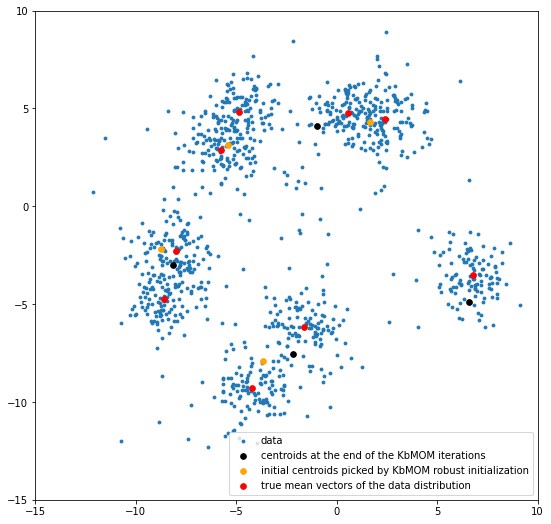

In [53]:
output_centroids = output['centroids']
list_all_centroids = output['list_of_all_quantile_block_centers_through_iterations']
initial_centroids = list_all_centroids[0]
number_of_block_to_plot = 1
for block_num in range(number_of_block_to_plot):
    plt.figure(figsize=(9,9))
    color_func = plt.get_cmap('tab10')
    plt.scatter(X[:,0],X[:,1],s=8,label='data')
    plt.scatter(output_centroids[:,0],output_centroids[:,1],s=32,c='black',label='centroids at the end of the KbMOM iterations')
    plt.scatter(initial_centroids[:,0],initial_centroids[:,1],s=32,c='orange',label='initial centroids picked by KbMOM robust initialization')
    plt.scatter(centers[:,0],centers[:,1],c='red',s=32,label='true mean vectors of the data distribution')
    plt.legend()
    plt.xlim(-15,10)
    plt.ylim(-15,10)
    plt.show()

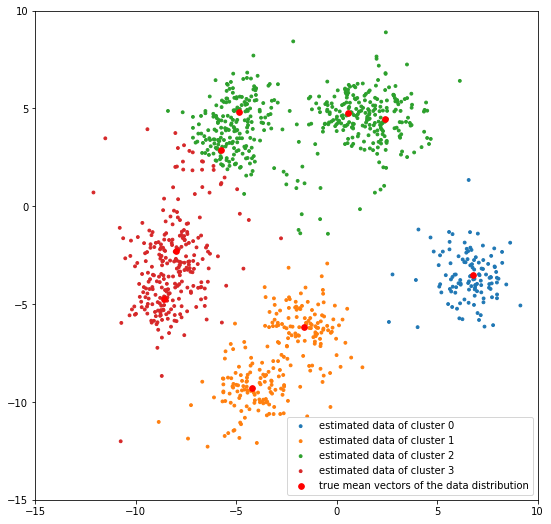

In [54]:
y_pred = output['labels']
number_of_block_to_plot = 1
plt.figure(figsize=(9,9))
color_func = plt.get_cmap('tab10')
for cluster in range(K):
    mask = y_pred == cluster
    plt.scatter(X[mask,0],X[mask,1],s=8,label=f'estimated data of cluster {cluster}',c=[color_func(cluster)]*sum(mask))
plt.scatter(centers[:,0],centers[:,1],c='red',s=32,label='true mean vectors of the data distribution')
plt.legend()
plt.xlim(-15,10)
plt.ylim(-15,10)
plt.show()

In [55]:
output['q_quantile_block_at_initialization']

[[393, 27, 699, 284, 179, 406, 922, 213, 314],
 [1029, 296, 316, 926, 423, 271, 1028, 769, 340, 835, 462, 492],
 [568, 851, 902, 1049, 368, 270, 305, 893, 917, 318],
 [285, 947, 1031, 7]]

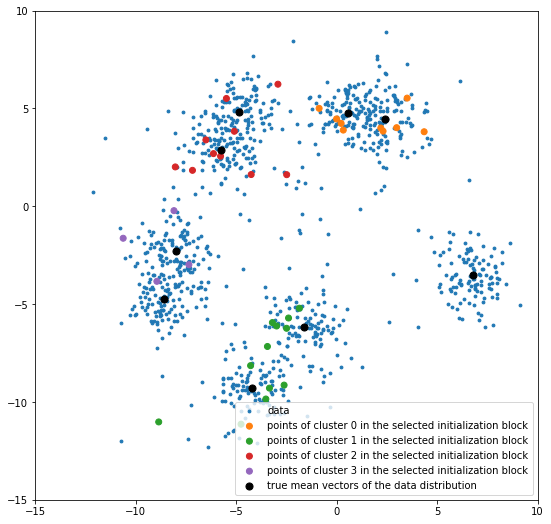

In [56]:
init_block = output['q_quantile_block_at_initialization']

plt.figure(figsize=(9,9))
color_func = plt.get_cmap('tab10')
plt.scatter(X[:,0],X[:,1],s=8,label='data')
for cluster_num,cluster in enumerate(init_block):
    plt.scatter(X[cluster,0],X[cluster,1],s=36,c=[color_func(cluster_num+1)]*len(cluster),label=f'points of cluster {cluster_num} in the selected initialization block')
plt.scatter(centers[:,0],centers[:,1],c='black',s=50,label='true mean vectors of the data distribution')
plt.legend()
plt.xlim(-15,10)
plt.ylim(-15,10)
plt.show()

### Let see how informative the data depth is

raw

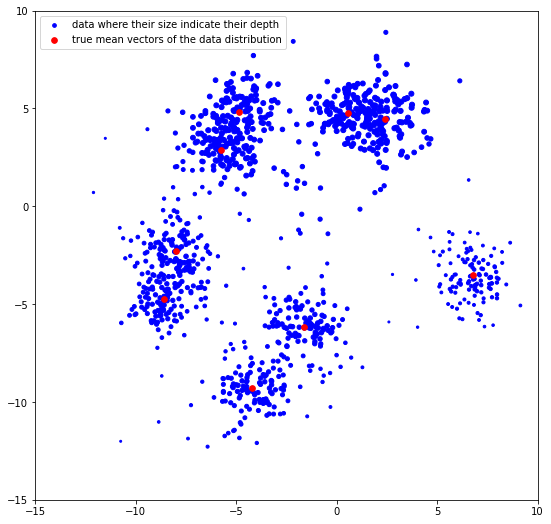

In [58]:
data_depth = output['data_depth']
number_of_block_to_plot = 1
for block_num in range(number_of_block_to_plot):
    plt.figure(figsize=(9,9))
    color_func = plt.get_cmap('tab10')
    plt.scatter(X[:,0],X[:,1],c='blue', label='data where their size indicate their depth',s=data_depth)
    plt.scatter(centers[:,0],centers[:,1],c='red',s=32,label='true mean vectors of the data distribution')
    plt.legend()
    plt.xlim(-15,10)
    plt.ylim(-15,10)
    plt.show()

Only plot data with big enough data depth

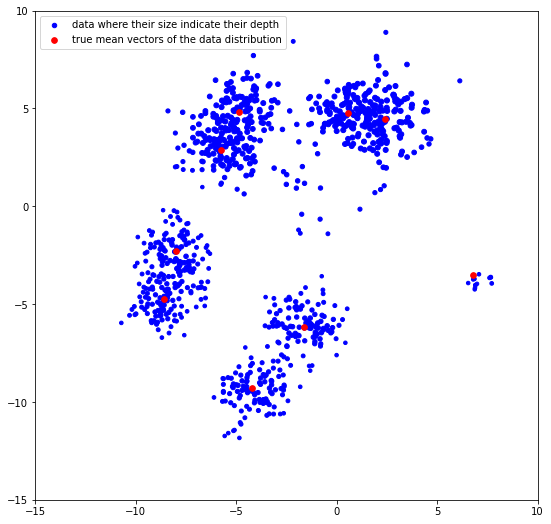

In [63]:
data_depth = output['data_depth']
mask = data_depth / data_depth.max() > 0.45 # i tried first 0.65, which was ok. and I tuned it with value among 0.75, 0.35, 0.50 and finally 0.45
number_of_block_to_plot = 1
plt.figure(figsize=(9,9))
color_func = plt.get_cmap('tab10')
plt.scatter(X[mask,0],X[mask,1],c='blue', label='data where their size indicate their depth',s=data_depth[mask])
plt.scatter(centers[:,0],centers[:,1],c='red',s=32,label='true mean vectors of the data distribution')
plt.legend()
plt.xlim(-15,10)
plt.ylim(-15,10)
plt.show()

One can see that the biggest depth are indeed the densest zone of the data.
In this case, one cluster has been almost discarded (the one on the right), but that is not problematic because the data depth should be used partition the data into "high data deptp zone" and "other zone". The data analyst must analyse the others zone as well.

In particular, a data analyst would see that there are 5 dense regions in the class of "high data depth zone" and that the noise has been reduced.
Consequently he will see that his K was too small (K=4).

In addition, one can analyse the "other zones" as a subset to be investigated. One would then see that there are interersting dense region there too.

### Show the overall risks at each iteration

(0.0, 65.0)

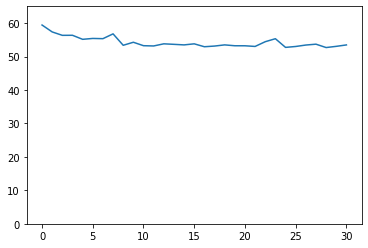

In [68]:
plt.plot(output['all_data_risks'])
plt.ylim(0,65)

One can see that after a few iteration, KbMOM found a better position and then fluctuated around 54

### Let us have a look a the sequence of centroids along iterations

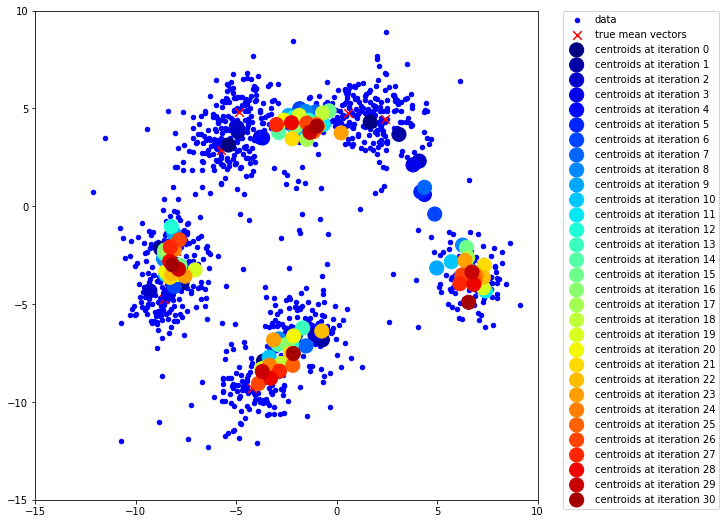

In [69]:
list_all_centroids = output['list_of_all_quantile_block_centers_through_iterations']
plt.figure(figsize=(9,9))
color_func = plt.get_cmap('jet')
plt.scatter(X[:,0],X[:,1],c='blue', label='data',s=20)
plt.scatter(centers[:,0],centers[:,1],c='red',s=75,label='true mean vectors',marker='x')
for i,centroids in enumerate(list_all_centroids):
    plt.scatter(centroids[:,0],centroids[:,1],c=[color_func(i/len(list_all_centroids))]*len(centroids),s=200,label=f'centroids at iteration {i}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlim(-15,10)
plt.ylim(-15,10)
plt.show()

## KbMOM - case where we use lots of centroids

in the preview case we took K=4.

This time, let us take K=11 to see how it behaves.

In [29]:
K = 11
max_iter = 30

In [30]:
kbmom = KbMOM(
    X=X,
    K=K,
    number_of_blocks=number_of_blocks,
    block_size = block_size,
    max_iter = max_iter,
    q_quantile = 0.5, # 0.5 means KbMOM will use the median as working quantile
    estimated_number_of_outliers = None,
    confidence = confidence,
    Aitkens_criterion_allowed = False,
    Aitkens_threshold = 0.00001,
    initial_centers = None, # KbMOM will initialize centroids
    init_by_kmeanspp = True, # KbMOM will use kmeans++ in its initialization procedure
    nb_min_repr_by_cluster = 2, # let force KbMOM to have 2 points of each cluster in all blocks
    data_depth_strategy="block_members_distances",
    random_state = 1
)

In [31]:
%%time

output = kbmom.fit(X)

CPU times: user 50.3 s, sys: 384 ms, total: 50.7 s
Wall time: 50.3 s


In [32]:
output.keys()

dict_keys(['centroids', 'labels', 'clusters_composition', 'q_quantile_block_at_initialization', 'convergence', 'data_depth', 'all_data_risks', 'quantile_block_risks', 'list_of_all_quantile_block_centers_through_iterations', 'number_of_blocks', 'block_size', 'n_iter'])

In [33]:
output['centroids']

array([[ 60.18983429, -30.21565921],
       [ -9.80542091,  -2.21163378],
       [ -4.97242114, -10.08719166],
       [ -3.79137759,   4.97997329],
       [ 14.24933815,  28.34487662],
       [ -4.64775959,   2.56726376],
       [  5.44067485,  -3.88912523],
       [ -8.32887354,  -4.67209239],
       [ -2.43853116,  -5.7276141 ],
       [ -6.31724645,   2.92952677],
       [  2.1290481 ,   4.97951678]])

One can see here that 2 of the centroids is far far away. But only 2 among 11, while there are around 17 wild outliers.

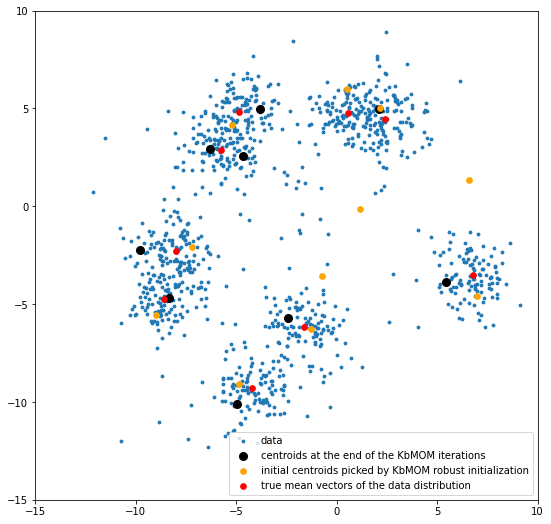

In [34]:
output_centroids = output['centroids']
list_all_centroids = output['list_of_all_quantile_block_centers_through_iterations']
initial_centroids = list_all_centroids[0]
number_of_block_to_plot = 1
for block_num in range(number_of_block_to_plot):
    plt.figure(figsize=(9,9))
    color_func = plt.get_cmap('tab10')
    plt.scatter(X[:,0],X[:,1],s=8,label='data')
    plt.scatter(output_centroids[:,0],output_centroids[:,1],s=64,c='black',label='centroids at the end of the KbMOM iterations')
    plt.scatter(initial_centroids[:,0],initial_centroids[:,1],s=32,c='orange',label='initial centroids picked by KbMOM robust initialization')
    plt.scatter(centers[:,0],centers[:,1],c='red',s=32,label='true mean vectors of the data distribution')
    plt.legend()
    plt.xlim(-15,10)
    plt.ylim(-15,10)
    plt.show()

One can see that the result is quite surprising. 9 of the centroids share the dense regions. There is at least 1 black point per dense region. The two spare centroids are set on the remote outliers.

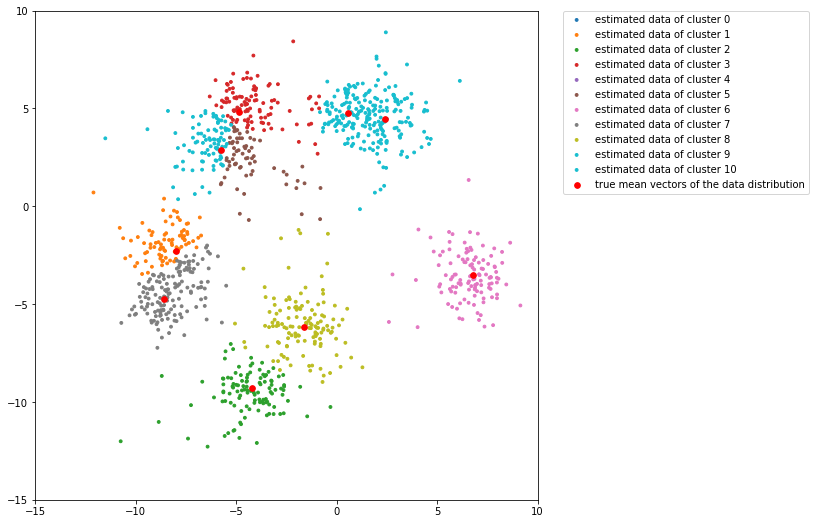

In [35]:
y_pred = output['labels']
number_of_block_to_plot = 1
plt.figure(figsize=(9,9))
color_func = plt.get_cmap('tab10')
for cluster in range(K):
    mask = y_pred == cluster
    plt.scatter(X[mask,0],X[mask,1],s=8,label=f'estimated data of cluster {cluster}',c=[color_func(cluster)]*sum(mask))
plt.scatter(centers[:,0],centers[:,1],c='red',s=32,label='true mean vectors of the data distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlim(-15,10)
plt.ylim(-15,10)
plt.show()

#### One ca nsee one the next plot which information the algorithm had at the initialization

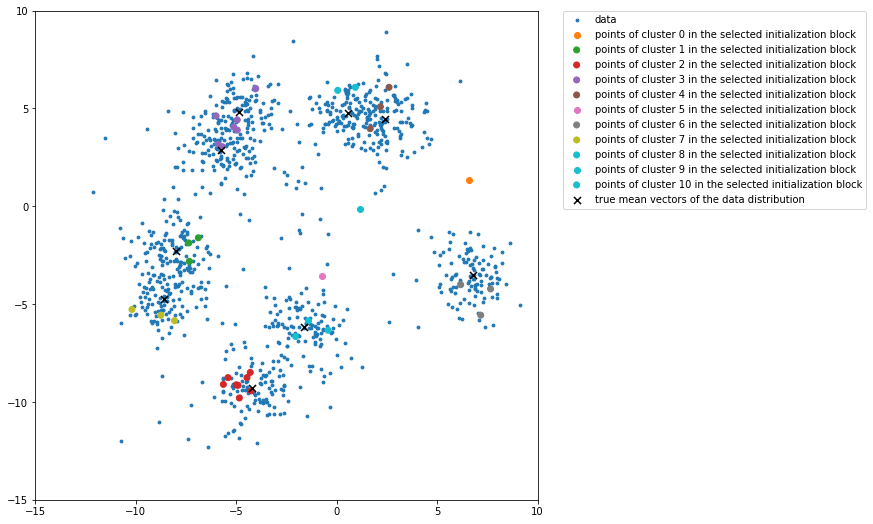

In [36]:
init_block = output['q_quantile_block_at_initialization']

plt.figure(figsize=(9,9))
color_func = plt.get_cmap('tab10')
plt.scatter(X[:,0],X[:,1],s=8,label='data')
for cluster_num,cluster in enumerate(init_block):
    plt.scatter(X[cluster,0],X[cluster,1],s=36,c=[color_func(cluster_num+1)]*len(cluster),label=f'points of cluster {cluster_num} in the selected initialization block')
plt.scatter(centers[:,0],centers[:,1],c='black',s=50,label='true mean vectors of the data distribution',marker="x")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlim(-15,10)
plt.ylim(-15,10)
plt.show()

### Let see how informative the data depth is

raw

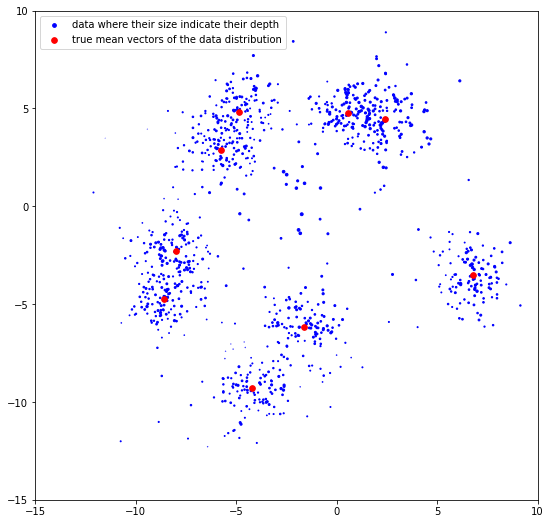

In [37]:
data_depth = output['data_depth']
number_of_block_to_plot = 1
for block_num in range(number_of_block_to_plot):
    plt.figure(figsize=(9,9))
    color_func = plt.get_cmap('tab10')
    plt.scatter(X[:,0],X[:,1],c='blue', label='data where their size indicate their depth',s=data_depth)
    plt.scatter(centers[:,0],centers[:,1],c='red',s=32,label='true mean vectors of the data distribution')
    plt.legend()
    plt.xlim(-15,10)
    plt.ylim(-15,10)
    plt.show()

Only plot data with big enough data depth

In [38]:
output['data_depth'][:20]/output['data_depth'].max()

array([0.15151861, 0.02746127, 0.06588633, 0.10058602, 0.05124038,
       0.03054748, 0.0474796 , 0.03594275, 0.11108122, 0.23921533,
       0.0986208 , 0.11742922, 0.01873217, 0.0802438 , 0.09829174,
       0.10598969, 0.16535574, 0.09523807, 0.08545926, 0.06696493])

(-15.0, 10.0)

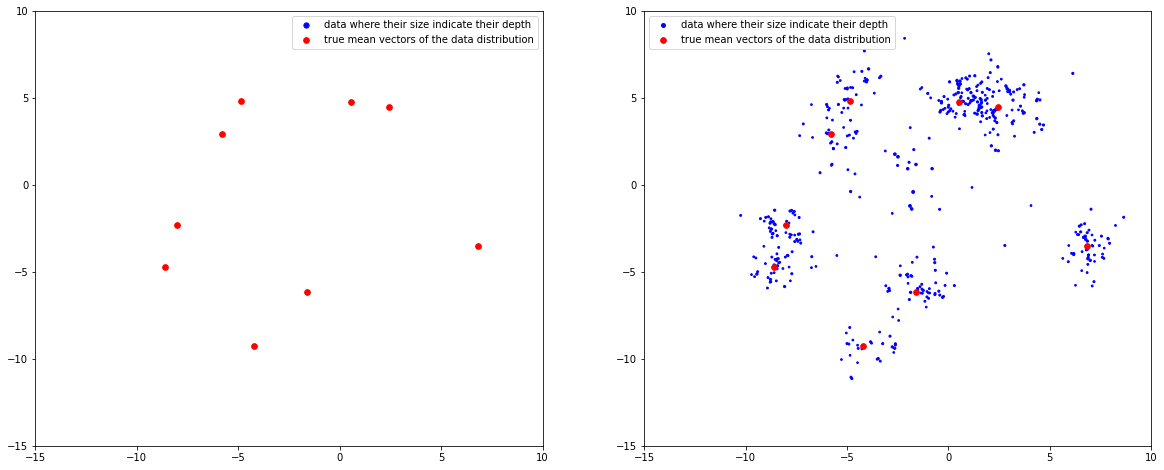

In [39]:
fig,ax = plt.subplots(1,2,figsize=(20,8))
data_depth = output['data_depth']
mask = data_depth / data_depth.max() > 0.65
number_of_block_to_plot = 1
color_func = plt.get_cmap('tab10')
ax[0].scatter(X[mask,0],X[mask,1],c='blue', label='data where their size indicate their depth',s=data_depth[mask])
ax[0].scatter(centers[:,0],centers[:,1],c='red',s=32,label='true mean vectors of the data distribution')
ax[0].legend()
ax[0].set_xlim(-15,10)
ax[0].set_ylim(-15,10)

mask = data_depth / data_depth.max() > 0.10 # i tried 0.35, 0.25, 0.15 before finding 0.1. It can be seen as cherry picking. Would I have chosen 0.1 if i did not know about the inlier?
number_of_block_to_plot = 1
color_func = plt.get_cmap('tab10')
ax[1].scatter(X[mask,0],X[mask,1],c='blue', label='data where their size indicate their depth',s=data_depth[mask])
ax[1].scatter(centers[:,0],centers[:,1],c='red',s=32,label='true mean vectors of the data distribution')
ax[1].legend()
ax[1].set_xlim(-15,10)
ax[1].set_ylim(-15,10)

The behaviour of the depth in this case is much more controversal.

### Show the overall risks at each iteration

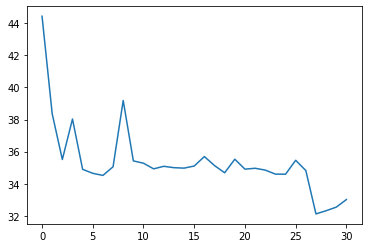

In [40]:
plt.plot(output['all_data_risks'])
# plt.ylim(0,13)

One can see that after a few iteration, KbMOM found a better position and then fluctuated around (53.5)

### Let us have a look a the sequence of centroids along iterations

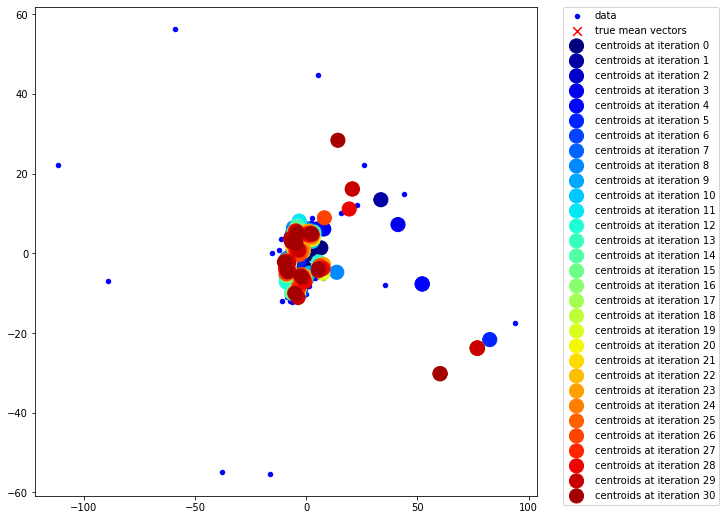

In [41]:
list_all_centroids = output['list_of_all_quantile_block_centers_through_iterations']
plt.figure(figsize=(9,9))
color_func = plt.get_cmap('jet')
plt.scatter(X[:,0],X[:,1],c='blue', label='data',s=20)
plt.scatter(centers[:,0],centers[:,1],c='red',s=75,label='true mean vectors',marker='x')
for i,centroids in enumerate(list_all_centroids):
    plt.scatter(centroids[:,0],centroids[:,1],c=[color_func(i/len(list_all_centroids))]*len(centroids),s=200,label=f'centroids at iteration {i}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.xlim(-15,10)
# plt.ylim(-15,10)
plt.show()

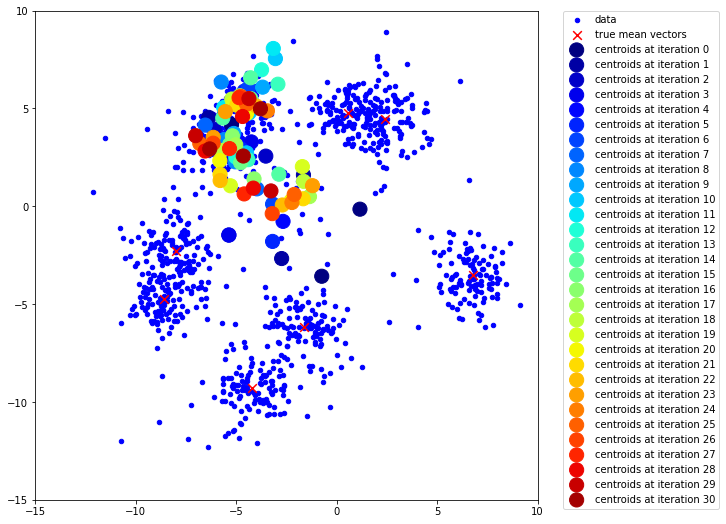

In [42]:
list_all_centroids = output['list_of_all_quantile_block_centers_through_iterations']
plt.figure(figsize=(9,9))
color_func = plt.get_cmap('jet')
plt.scatter(X[:,0],X[:,1],c='blue', label='data',s=20)
plt.scatter(centers[:,0],centers[:,1],c='red',s=75,label='true mean vectors',marker='x')
cluster_num = [3,5,9]
for i,centroids in enumerate(list_all_centroids):
    plt.scatter(centroids[cluster_num,0],centroids[cluster_num,1],c=[color_func(i/len(list_all_centroids))]*len(cluster_num),s=200,label=f'centroids at iteration {i}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlim(-15,10)
plt.ylim(-15,10)
plt.show()

one can see that the clusters 4, 6 and 10 competed for a dense regions. Cluster 6 (bottom) did not leave the regions to others for free because at the middle of the iterations it fought back the the region.

The migration of the centroids can also indicate that some regions of the space are interesting. In this case, better analysis would show that three centroids competed for only one regions of space.